## 필요한 패키지들을 Import 합니다.

In [2]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.spatial import distance
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import euclidean_distances
from sklearn.metrics import silhouette_score

# For Visualization
import matplotlib.pyplot as plt
import matplotlib
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

## 데이터를 불러와 필요한 열만 추출 후 jeju_df에 저장합니다.
20대 남성, 여성만 추출하여 합하고, 유동인구비율을 제외한 유동인구만 추출합니다.

In [3]:
df=pd.read_csv('data.csv',encoding='cp949')

In [4]:
df.head()

,direction,10M,20M,30M,40M,50M,60M,10F,20F,30F,40F,50F,60F
0,다다06A00A,26.18,155.23,301.76,376.38,295.98,130.88,26.13,155.98,245.56,249.72,188.04,123.29
1,다다06A02D,1.44,7.93,20.27,26.37,23.49,9.49,1.54,9.20,16.31,16.49,15.39,6.68
2,다다00C00D,0.92,2.31,11.85,14.99,10.62,4.25,0.53,2.20,10.66,8.74,6.29,2.51
3,나나98C73A,3.25,8.59,16.52,15.66,11.74,7.15,4.00,12.02,17.82,12.84,10.80,7.21
4,나나98B74A,0.60,2.01,3.89,4.17,3.40,1.98,0.78,2.78,3.92,2.84,2.72,1.78


In [25]:
jeju_df=pd.DataFrame()

In [26]:
jeju_df['floating_pop']=df['20M']+df['20F']

In [27]:
jeju_df.head()

,floating_pop
0,311.21
1,17.13
2,4.51
3,20.61
4,4.79


### 250m 격자좌표를 x,y 좌표로 변환하기 위해 파일을 열고 해당 격자좌표에 맞는 x,y축을 jeju_df에 저장합니다.

In [28]:
dir_df=pd.read_csv('directions.csv',encoding='cp949')

In [29]:
dir_df.head()

,x,y,direction
0,884875.0001,1458875,나나84D58D
1,885125.0001,1458875,나나85D58A
2,884875.0001,1459125,나나84A59D
3,885125.0001,1459125,나나85A59A
4,884875.0001,1459375,나나84B59D


In [30]:
x=[dir_df.x[df.direction[i] == dir_df.direction.values].values[0] for i in range(0,df.shape[0])]

In [31]:
y=[dir_df.y[df.direction[i] == dir_df.direction.values].values[0] for i in range(0,df.shape[0])]

In [32]:
jeju_df['x']=x
jeju_df['y']=y

## 유동인구(20대 남성+여성), x 위치, y위치로 이루어진 데이터프레임이 생성됬습니다.

In [33]:
jeju_df.head()

,floating_pop,x,y
0,311.21,906125.0001,1500125
1,17.13,906875.0001,1502125
2,4.51,900875.0001,1500625
3,20.61,898125.0001,1473625
4,4.79,898125.0001,1474375


## Elbow_Method 클래스를 정의합니다.
### 이 클래스는 적당한 군집 수를 알아보기 위함이며, 군집 개수별로 편차제곱합, 설명력을 그래프로 나타냅니다.

In [57]:
def Elbow_Method(data):
    K = range(10,31,5) # 10~30까지 군집개수를 5개 단위로 검증합니다. (10,15,20...30)
    KM = [KMeans(n_clusters=k).fit(jeju_df) for k in K]
    centroids = [k.cluster_centers_ for k in KM]
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids] # 중심으로부터 유클리디안 거리를 사용합니다.
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    

    # elbow curve
    fig = plt.figure() # 그래프를 생성합니다.
    ax = fig.add_subplot(111)
    
    kIdx = 1
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=10, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    
    kIdx = 2
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=10, 
    markeredgewidth=2, markeredgecolor='b', markerfacecolor='None')
    
    kIdx = 3
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=10, 
    markeredgewidth=2, markeredgecolor='g', markerfacecolor='None')  
    
    kIdx = 4
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=10, 
    markeredgewidth=2, markeredgecolor='y', markerfacecolor='None') 
    
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')

## 첫 번째 그래프는 군집 개수(X축)별 편차제곱합(y축)입니다.
### 변인 값과 평균 사이의 편차를 제곱한 값들의 총합으로 y축 값이 낮을 수록 좋은 개수를 의미합니다.

## 두 번째 그래프는 군집 개수(X축)별 설명력(y축)입니다.
### 설명력을 나타내는 그래프로 y축 값이 높을 수록 좋은 개수를 의미합니다.

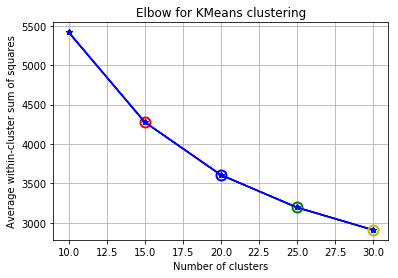

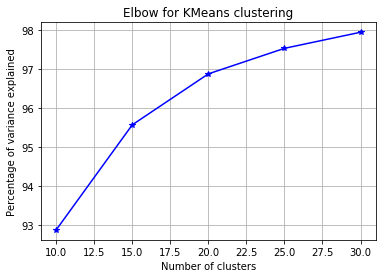

In [58]:
Elbow_Method(jeju_df)

## 3차원 공간에서 군집을 확인하기 위해 3차원 공간을 생성하고 데이터를 변환해줍니다.

#### jeju_df가 (유동인구,x,y) 3차원 데이터이기 때문입니다.

In [50]:
scaler = StandardScaler().fit(jeju_df)
Values_Scaled = scaler.transform(jeju_df)

In [51]:
Values_Reduced_3D = PCA(n_components=3).fit_transform(Values_Scaled)

## 아래 그래프는 3차원 공간에서 30개의 군집으로 나눈 결과를 볼 수 있습니다.

### 같은 색깔이 한 군집을 나타내며 x표시는 그 군집에 중심에 해당하는 값입니다.

[]

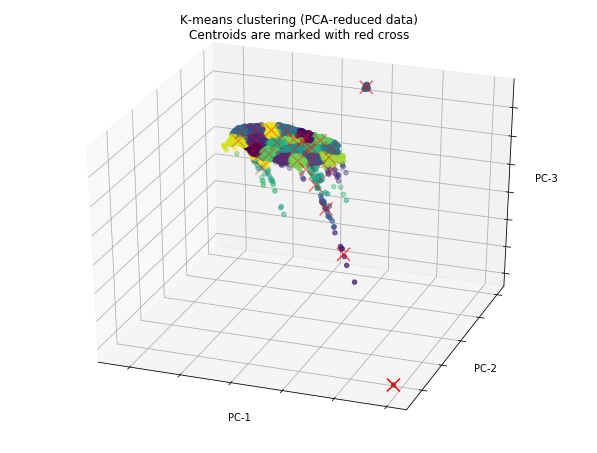

In [54]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=250)
kmeans = KMeans(init='k-means++', n_clusters=30, n_init=10)
kmeans.fit(Values_Reduced_3D)
ax.scatter(Values_Reduced_3D[:, 0], Values_Reduced_3D[:, 1], Values_Reduced_3D[:, 2], 
           c=kmeans.labels_.astype(np.float)
          )
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],  centroids[:, 2],
            marker='x', s=169, linewidths=3, 
           c='r')
ax.set_title('K-means clustering (PCA-reduced data)\n'
             'Centroids are marked with red cross')
ax.set_xlabel("PC-1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC-2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC-3")
ax.w_zaxis.set_ticklabels([])

## 군집 케이스와 중심 값을 저장하여 csv로 저장합니다.

In [59]:
kmeans = KMeans(n_clusters=30, random_state=0).fit(jeju_df)

In [64]:
jeju_df['cl_label']=kmeans.labels_

In [66]:
jeju_df.head()

,floating_pop,x,y,cl_label
0,311.21,906125.0001,1500125,8
1,17.13,906875.0001,1502125,8
2,4.51,900875.0001,1500625,11
3,20.61,898125.0001,1473625,23
4,4.79,898125.0001,1474375,23


In [73]:
cl_center=pd.DataFrame(kmeans.cluster_centers_, columns=['floating_pop','x','y'])

In [74]:
cl_center.head()

,floating_pop,x,y
0,0.657807,896426.807329,1.491420e+06
1,0.426199,919361.111211,1.488624e+06
2,0.959607,939046.478160,1.502919e+06
3,3.099387,913194.853041,1.476153e+06
4,1.054482,890376.273445,1.476768e+06


In [75]:
jeju_df.to_csv('cl_jeju.csv')

In [76]:
cl_center.to_csv('cl_center.csv')